In [1]:
# coding : utf-8
import sys, os, math
from collections import defaultdict
import itertools
from graphviz import Digraph

num_of_pos = 0
num_of_neg = 0

count_dict = defaultdict(lambda: 0)

In [2]:
with open("train.txt") as train_file:
    for line in train_file:
        line_lst = line.strip().split(",")
        
        tag = ""
        if line_lst[-1] == "positive":
            tag = "p"
            count_dict["_p"] +=1
        else:
            tag = "n"
            count_dict["_n"] +=1
            

        for i in range(9):
#             context[line_lst[i] + "%d"%(i)] += 1            
            count_dict[line_lst[i] + "%d"%(i) + "_" + tag] += 1
            count_dict[line_lst[i] + "%d"%(i)] += 1

            for j in range(i+1, 9):
                count_dict[line_lst[i] + "%d"%(i) + "_" + line_lst[j] + "%d"%(j) + "_" + tag] +=1
                count_dict[line_lst[i] + "%d"%(i) + "_" + line_lst[j] + "%d"%(j)] +=1   

In [3]:
# for key,  value in (sorted(count_dict.items()) ):
#     print(key, value)

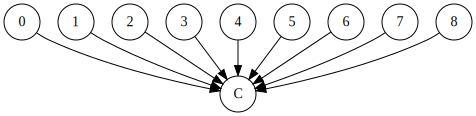

In [4]:
# formatはpngを指定(他にはPDF, PNG, SVGなどが指定可)
Graph = Digraph(format='png')
Graph.attr('node', shape='circle')

N = 9    # ノード数

condition = Digraph('condition')
condition.graph_attr.update(rank='min')

# ノードの追加
for i in range(N):
    condition.node(str(i), str(i))
    Graph.edge(str(i), "C")
Graph.node("C", "C")
Graph.subgraph(condition)

prev = ""

# for next, prev in Next(pointer_map, None , "0"):
#     Graph.edge(next, "C")
    


Graph

In [5]:
def predict_NB(feature):
    p_pos = 0
    p_neg = 0

    for i in range(9):
        p_pos += math.log(count_dict["%s%d_p"%(feature[i], i)] / count_dict["_p"] )
        p_neg += math.log(count_dict["%s%d_n"%(feature[i], i)] / count_dict["_n"] )

    p_pos += math.log(count_dict["_p"]/(count_dict["_p"] + count_dict["_n"]))
    p_neg += math.log(count_dict["_n"]/(count_dict["_p"] + count_dict["_n"]))

    return (p_pos, p_neg)
    

In [6]:
accurate = 0
num_test = 0
with open ("test.txt", "r") as test_file:
    # line = test_file.readline()
    for line in test_file:
        num_test += 1
        line_lst = line.strip().split(",")
        
        if len(line_lst) != 10:
            continue
            
        p_pos, p_neg = predict_NB(line_lst[:-1])
        
        result = "positive" if p_pos > p_neg else "negative"
        
        if result == line_lst[-1]:
            accurate += 1
            
        print(",".join(line_lst) + ", " + result, ", %10.5f, %10.5f" % (p_pos, p_neg))

    print("accuracy=%d/%d=%0.3f" % ( accurate, num_test, (accurate / num_test)))

x,x,x,x,o,o,x,o,o,positive, negative ,   -9.70569,   -9.44937
x,x,x,x,o,o,o,x,o,positive, negative ,  -10.17513,   -8.85951
x,x,x,x,o,o,o,o,x,positive, negative ,   -9.69306,   -9.44937
x,x,x,x,o,o,o,b,b,positive, negative ,  -10.76071,  -10.23415
x,x,x,x,o,o,b,o,b,positive, positive ,  -10.75572,  -10.80932
x,x,x,x,o,o,b,b,o,positive, negative ,  -10.75892,  -10.23415
x,x,x,x,o,b,o,o,b,positive, negative ,  -10.75312,  -10.15195
x,x,x,x,o,b,o,b,o,positive, negative ,  -10.75633,   -9.57678
x,x,x,x,o,b,b,o,o,positive, negative ,  -10.75134,  -10.15195
x,x,x,x,b,o,o,o,b,positive, positive ,  -10.67086,  -11.37736
x,x,x,x,b,o,o,b,o,positive, positive ,  -10.67407,  -10.80218
x,x,x,x,b,o,b,o,o,positive, positive ,  -10.66908,  -11.37736
x,x,x,o,x,o,x,o,o,positive, positive ,   -8.70786,  -10.65262
x,x,x,o,x,o,o,x,o,positive, positive ,   -9.17730,  -10.06275
x,x,x,o,x,o,o,o,x,positive, positive ,   -8.69523,  -10.65262
x,x,x,o,x,o,o,b,b,positive, positive ,   -9.76287,  -11.43739
x,x,x,o,

# TAN

In [7]:
#両ノードが繋がるかの判定
def isLead(graph, pre, start, end):
    for edge in graph:
        if edge in ["%s_%s"%(start, end), "%s_%s"%( end, start)]:
            return True
        else:
            try:
                nodes = edge.split("_")
                i = nodes.index(start)
                next = nodes[( i + 1 ) % 2]
                if (next != pre) and (isLead(graph, start, next, end)):
                    return True
            except:
                pass
    return False

# for test
# edges = ["5_6","1_8","1_6"]
# print("\n", isLead(edges, None, '1', '5'))
# print("stack=",stack)
 #for test

In [8]:
#mutual_information
#変数間の相互情報量の計算
def calc_mutal_info(index_i, index_j): 
    info = 0
    val = ["x", "b", "o"]
    total = count_dict["_p"] + count_dict["_n"]
    for x in val:
        for y in val:
            p_xy = count_dict["%s%d_%s%d"%(x, index_i, y, index_j)]/total
            p_x   = count_dict["%s%d"%(x, index_i)]/total
            p_y   = count_dict["%s%d"%(y, index_j)]/total
            if p_xy != 0:
                info += (p_xy * math.log(p_xy/(p_x * p_y), 10))
    return info



In [9]:
edges = []

#相互情報量辞書
Mutal_Infos = defaultdict(lambda:0) 

#相互情報量の計算　N(N　-　1)/2個
for i in range(9):
    for j in range(i + 1, 9):
        Mutal_Infos["%d_%d"%(i, j)] = calc_mutal_info(i, j)

for key, value in sorted(Mutal_Infos.items(), reverse=True, key = lambda x : x[1]):
    print(key, value)

3_8 0.019782825432049702
5_6 0.019526920766330707
2_3 0.018759031401299635
0_5 0.017955739738288432
1_6 0.01759384174893576
0_7 0.017214847272061577
1_8 0.016962972311160063
2_7 0.016563381652488416
3_7 0.010088104184042802
5_7 0.009926767758572274
1_3 0.009504614609088118
1_5 0.00820644569096572
0_2 0.005580581311564211
4_6 0.0038997482674830337
4_8 0.0034844764407076945
6_8 0.0033076683630938845
0_4 0.00308417673173532
4_7 0.003065233534225935
3_4 0.0029264492809906693
2_4 0.002883743432476409
1_7 0.002853386375935106
4_5 0.00259503521037773
2_8 0.0025380037038870984
0_6 0.002464997183549896
1_4 0.0022893952410671407
0_1 0.002054249725627258
3_5 0.0019942839026915672
1_2 0.0009692340084882243
5_8 0.000617843640968483
0_3 0.0005609984130840978
2_5 0.0004774020537700037
3_6 0.00037242033872307177
6_7 0.00036969111068065443
7_8 0.00033526296313499517
2_6 4.680603883542396e-05
0_8 1.9500676248875108e-05


In [10]:
# ロープが出来ないようにn-1個のエッジを木に入れる

selected_edges = set()
for key, value in sorted(Mutal_Infos.items(), reverse=True, key = lambda x : x[1]):
    n1, n2 = key.split("_")
    
    #両ノードが既に繋がる場合selected_edgesに入れない
    if not isLead(selected_edges, None, n1, n2):
        selected_edges.add(key)
        
    #　この条件式が無くても排他的繋がるエッジは　N−１しか無いのでN-1以上のエッジを選ぶ事絶対無い
    if len (selected_edges) >= 9-1:
        break

for i, edge in enumerate(selected_edges):
    print(i, edge)

Condition_Map = defaultdict(lambda:-1)

def add_to_condition_map(prev, start, condition_map, candidate_edges):

    condition_map[start] = prev
    
    for edge in candidate_edges:
        n1, n2 = edge.split("_")
        n1 = int(n1)
        n2 = int(n2)
#         print(n1, n2)
        if start in [n1,n2]:
            next = n1 if start == n2 else int(n2)
            if next != prev :
                
#                 print("%d_%d"%(start, next))
                add_to_condition_map(start, next, condition_map, candidate_edges)
#         else:
#             print("not found")
START = 0

add_to_condition_map(-1, START, Condition_Map, selected_edges)

for i in range(9):
    print(Condition_Map[i], i)

0 5_6
1 3_8
2 4_6
3 1_6
4 2_3
5 1_8
6 0_5
7 0_7
-1 0
6 1
3 2
8 3
6 4
0 5
5 6
0 7
1 8


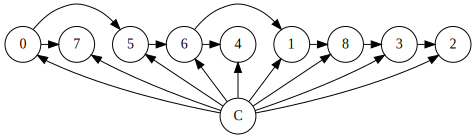

In [11]:
# formatはpngを指定(他にはPDF, PNG, SVGなどが指定可)
Graph = Digraph(format='png')
Graph.attr('node', shape='circle')

N = 9    # ノード数

condition = Digraph('condition')
condition.graph_attr.update(rank='min')

# ノードの追加
for i in range(N):
    condition.node(str(i), str(i))
    Graph.edge("C", str(i))
Graph.node("C", "C")
Graph.subgraph(condition)

for key, value in Condition_Map.items():
    if value != -1:
        Graph.edge(str(value), str(key))

Graph

In [12]:
def predict_TAN(features, condition_map):
    p_pos = 0
    p_neg = 0
    
    for i in range(9):
        
        next = i
        prev = condition_map[next]
        
        if prev == -1:
            p_pos += math.log(count_dict["%s%d_p"%(features[next], next)] / num_of_pos )
            p_neg += math.log(count_dict["%s%d_n"%(features[next], next)] / num_of_neg )
        else:
#             prev = int(prev)

            first = min(next, prev)
            second = max (next, prev)

#                 print("%s%d_%s%d_p= %f"%(line_lst[first], first, line_lst[second], second, count_dict["%s%d_%s%d_p"%(line_lst[first], first, line_lst[second], second)] ))

            p_pos += math.log(count_dict["%s%d_%s%d_p"%(line_lst[first], first, features[second], second)] / count_dict["%s%d_p"%(features[prev], prev)])    
            p_neg += math.log(count_dict["%s%d_%s%d_n"%(line_lst[first], first, features[second], second)] / count_dict["%s%d_n"%(features[prev], prev)])    

    p_pos += math.log(count_dict["_p"]/(count_dict["_p"] + count_dict["_n"]))
    p_neg += math.log(count_dict["_n"]/(count_dict["_p"] + count_dict["_n"]))
        
    return (p_pos, p_neg)

In [13]:
accurate = 0
num_test = 0
with open ("test.txt", "r") as test_file:
    num_of_pos = count_dict["_p"]
    num_of_neg = count_dict["_n"]
    # line = test_file.readline()
    for line in test_file:
        num_test += 1
        line_lst = line.strip().split(",")
        
        if len(line_lst) != 10:
            continue
            
        p_pos, p_neg = predict_TAN(line_lst[:-1], Condition_Map)
        
        result = "positive" if p_pos > p_neg else "negative"
        
        if result == line_lst[-1]:
            accurate += 1
            
        print(",".join(line_lst) + ", " + result, ", %10.5f, %10.5f" % (p_pos, p_neg))

    print("accuracy=%d/%d=%0.3f" % ( accurate, num_test, (accurate / num_test)))

x,x,x,x,o,o,x,o,o,positive, negative ,   -9.20666,   -8.16737
x,x,x,x,o,o,o,x,o,positive, negative ,  -10.90027,   -9.22974
x,x,x,x,o,o,o,o,x,positive, negative ,  -11.38052,  -10.19389
x,x,x,x,o,o,o,b,b,positive, positive ,  -10.85744,  -11.36031
x,x,x,x,o,o,b,o,b,positive, negative ,  -10.48022,  -10.33995
x,x,x,x,o,o,b,b,o,positive, negative ,  -10.42503,   -9.45418
x,x,x,x,o,b,o,o,b,positive, negative ,  -10.62601,  -10.35785
x,x,x,x,o,b,o,b,o,positive, negative ,  -10.57083,   -9.47208
x,x,x,x,o,b,b,o,o,positive, negative ,  -10.47618,  -10.06605
x,x,x,x,b,o,o,o,b,positive, positive ,  -10.51643,  -11.55060
x,x,x,x,b,o,o,b,o,positive, positive ,  -10.46125,  -10.66483
x,x,x,x,b,o,b,o,o,positive, positive ,  -10.31430,  -10.32965
x,x,x,o,x,o,x,o,o,positive, positive ,   -8.56306,  -10.28220
x,x,x,o,x,o,o,x,o,positive, positive ,   -9.20736,  -10.46803
x,x,x,o,x,o,o,o,x,positive, positive ,   -8.14437,   -9.70104
x,x,x,o,x,o,o,b,b,positive, positive ,   -8.92206,  -10.97847
x,x,x,o,

# BAN
## step1
説明変数$X_i$と目的変数Cの相互情報量$I(X_i,C)$を全ての$i$に関して求め、大きい順にソートする。

In [14]:
Mutal_Infos_X_and_Class = defaultdict(lambda : 0)


def calc_mutal_info_x_and_class(index_i):
    total = count_dict["_n"] + count_dict["_p"]
    
    sum = 0
    for x in ["x", "o", "b"]:
        for c in ["p", "n"]:
            
            #x_1, x_2, 0_3,b_1 etc.
            x_num = "%s%d"%(x, index_i)
            
            p_xc = count_dict[x_num + "_" + c]  / total
            p_x   = count_dict[x_num] / total
#             print(p_xc, p_x)
            p_c   = (count_dict["_" + c]) / total
            sum += p_xc * math.log(p_xc / (p_x * p_c), 10)
    return sum

for i in range(9):
    mutal_info_x_and_class = calc_mutal_info_x_and_class(i)
    Mutal_Infos_X_and_Class["%d"%(i)] = mutal_info_x_and_class
    print("%d_c = %f"%(i, mutal_info_x_and_class))
    
sum_of_info = 0

Node_Order_Dict=dict()

for order, (key, value) in enumerate(sorted(Mutal_Infos_X_and_Class.items(), key=lambda x: x[1], reverse =True)):
    print(key, value)
    Node_Order_Dict[key] = order
    sum_of_info += value

print("\nThe summation of mutal information x and class is: \n%f"%(sum_of_info))

0_c = 0.004417
1_c = 0.004452
2_c = 0.002845
3_c = 0.001844
4_c = 0.030210
5_c = 0.001841
6_c = 0.004879
7_c = 0.001226
8_c = 0.005030
4 0.030209947823986658
8 0.005029621839558685
6 0.004879330464763563
1 0.004452061616587057
0 0.00441743861282165
2 0.002844922505862481
3 0.0018437967049976722
5 0.0018410424223542423
7 0.0012261649513406947

The summation of mutal information x and class is: 
0.056744


## Step2
以下の不等式を満たすようなｋの最小値を求める,Nは変数数、ｋは説明変数間に引かれるエッジの数の許容最大数を表す。
    $$\sum\limits_{j=i}^k I(X_j,C)\geq t_{cx}\sum\limits_{j=1}^NI(X_j,C)\\ 但し、0<t_{cx}<1$$

In [15]:
t_cx = 1
t_xx = 1

k = 0 #
sum_of_k = 0
var_k =[]
for key, value in sorted(Mutal_Infos_X_and_Class.items(), key=lambda x: x[1], reverse =True):
    k += 1
    sum_of_k += value
    var_k.append(int(key))
    print(k, key, sum_of_k)
    if sum_of_k >= t_cx * sum_of_info:
        break

print("\n許容最大数：\nk=%d"%(k))

1 4 0.030209947823986658
2 8 0.03523956966354534
3 6 0.040118900128308904
4 1 0.044570961744895964
5 0 0.048988400357717614
6 2 0.0518333228635801
7 3 0.05367711956857777
8 5 0.05551816199093201
9 7 0.05674432694227271

許容最大数：
k=9


In [16]:
print(var_k)

[4, 8, 6, 1, 0, 2, 3, 5, 7]


## step 3
Cを所有とした時の説明変数間の相互情報量$I(X_i,X_j|C)$を、ステップ２で選択したｋ個の変数の全組み合わせについて求め、大きい順にソートする。

*Cを所有とした時の変数間の相互情報量の公式：
$$I(X,Y|C)=\sum\limits_{x,y,c}P(x,y,c)\log \frac{P(x,y|c)}{P(x|c)P(y|c)}$$

In [17]:
#Classを所与とした時の相互情報量
def calc_mutal_info_with_class(index_i, index_j): 
    mutal_info = 0
    val = ["x", "b", "o"]
    num_of_pos = count_dict["_p"]
    num_of_neg = count_dict["_n"]
    total = num_of_pos + num_of_neg
    for x in val:
        for y in val:
            for c in["n","p"]:
                num_of_c = count_dict["_%s"%( c)]
                p_xyc = count_dict["%s%d_%s%d_%s"%(x, index_i, y, index_j, c)]/total
                p_xy_in_c   = count_dict["%s%d_%s%d_%s"%(x, index_i, y, index_j, c)]/num_of_c
                p_x_in_c = count_dict["%s%d_%s"%(x, index_i, c)]/num_of_c
                p_y_in_c = count_dict["%s%d_%s"%(y, index_j, c)]/num_of_c
            if p_xy_in_c != 0:
                mutal_info += (p_xyc * math.log(p_xy_in_c/(p_x_in_c * p_y_in_c), 10))
    return mutal_info

In [18]:
comb_list = list(itertools.combinations(var_k, 2))
Mutal_Infos_With_Class = defaultdict(lambda:0)

for comb in comb_list:
    
    # 必ず昇順にすること
    i, j = sorted(comb)
    Mutal_Infos_With_Class["%d,%d"%(i, j)] = calc_mutal_info_with_class(i, j)

    
sum_mutal_info_with_class_with_k_var=0

for i, (key, info) in enumerate(sorted(Mutal_Infos_With_Class.items(), key = lambda x:x[1], reverse = True)):
    if i >= k:
        break
    print("I(%s|C)="%(key), info)
    sum_mutal_info_with_class_with_k_var += info
    

print("\nk個までの総和=%f"%(sum_mutal_info_with_class_with_k_var))

I(2,3|C)= 0.015193375538017409
I(5,6|C)= 0.015108711040315794
I(3,8|C)= 0.014041338526282155
I(0,5|C)= 0.012804623962153927
I(0,7|C)= 0.011722711589206304
I(2,7|C)= 0.011722711589206304
I(1,6|C)= 0.011190591674865424
I(1,8|C)= 0.010405066744874136
I(1,3|C)= 0.009055025567807221

k個までの総和=0.111244


## step4
ステップ３でソートされた相互情報量を順に足して行き、許容最大数$k$までの総和の$t_{xx}$パーセント$t_{xx}\sum\limits_{i<j}^{k}I(X_i,X_j|C)$($t_{xx}$はユーザが決める)を超えるまで足していく。この時足された変数間にリンクを引く。

In [24]:
partial_info_with_k_var = 0
# print(Node_Order_Dict)
edges_selected = set()

for key, info in sorted(Mutal_Infos_With_Class.items(), key=lambda x:x[1], reverse=True):
    partial_info_with_k_var += info
    
    
    # ノードをステップ１て求めた情報量の大きい順に並べ替える
    n1, n2= key.split(",")
    edge = "%s,%s"%(n1,n2)if Node_Order_Dict[n1] < Node_Order_Dict[n2] else "%s,%s"%(n2, n1)
    
    edges_selected.add(edge)
    
    if partial_info_with_k_var >= t_xx * sum_mutal_info_with_class_with_k_var:
        break
        
print(partial_info_with_k_var)
print(edges_selected)

Condition_Map = defaultdict(lambda:[])

for edge in edges_selected:
    n1, n2 = edge.split(",")
    n1 = int(n1)
    n2 = int(n2)
    Condition_Map[n2].append(n1)
    
print("#####")
#条件部の変数数が２以上の場合再カウントする
recount_keys = list()
for target_var, cond_var in Condition_Map.items():
    if len(cond_var)>=2 :
    
        cond_var = sorted(cond_var)
        if len(cond_var) >2:
            recount_keys.append(cond_var)
        all_var = sorted(cond_var + [target_var])
        recount_keys.append(all_var)
        
# print(Condition_Map)
print(recount_keys)

0.11124415623272868
{'8,3', '0,5', '2,7', '8,1', '2,3', '0,7', '6,5', '1,3', '6,1'}
#####
[[1, 6, 8], [1, 2, 8], [1, 2, 3, 8], [0, 5, 6], [0, 2, 7]]


In [20]:
nnum = 0
with open("train.txt") as train_file:
    for line in train_file:
        line_lst = line.strip().split(",")
        
        tag = ""
        if line_lst[-1] == "positive":
            tag = "p"
        else:
            tag = "n"
            

        for count_key in recount_keys:
            key_list = ["%s" + str(key) for key in count_key] # number list of features example as ["%s1", "%s3"]
            key_list_text = "_".join(key_list) #join with "_", example as "%s1_%s3"
            #tuple([line_lst[i] for  i in count_key]) value for number of keys.
#             print(nnum, key_list_text%(tuple([line_lst[i] for  i in count_key])) +"_"+tag)
            nnum+=1
            
            count_dict[key_list_text%(tuple([line_lst[i] for  i in count_key])) +"_"+tag] +=1
# count_dict["_p"]  +count_dict["_n"]

{'8,3', '0,5', '2,7', '8,1', '2,3', '0,7', '6,5', '1,3', '6,1'}


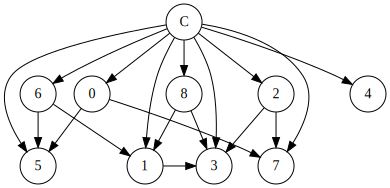

In [21]:
# formatはpngを指定(他にはPDF, PNG, SVGなどが指定可)
Graph = Digraph(format='png')
Graph.attr('node', shape='circle',rankdir='TB')

N = 9    # ノード数

condition1 = Digraph('condition1')
condition2 = Digraph('condition2')

condition1.graph_attr.update(rank='same')
condition2.graph_attr.update(rank='same')

level1_set={int(edge[2]) for edge in edges_selected}


# ノードの追加



for i in range(9):
    if i not in level1_set:
        condition1.node(str(i), str(i))
        Graph.edge("C",str(i))

for i in level1_set:
    condition2.node(str(i), str(i))
    Graph.edge("C",str(i))
    
Graph.subgraph(condition1)
Graph.subgraph(condition2)
Graph.node("C", "C")

prev = ""


print(edges_selected)
    
for edge in edges_selected:
    n1, n2 = edge.split(",")
    [first, second] = [n1,n2] if Node_Order_Dict[n1] < Node_Order_Dict[n2] else  [n2, n1]
    Graph.edge(first, second)
    
# print()するとdot形式で出力される
Graph

In [22]:
def predict_BAN(features, condition_map):
    num_of_pos = count_dict["_p"]
    num_of_neg = count_dict["_n"]
    
    p_pos = 0
    p_neg = 0
    
    for feat_var_index in range(9):
        
        # feat_var_index : 目的変数
        # 親変数リスト
        parent_vars_index_list = condition_map[feat_var_index]
        
        # 親が無い場合
        if not parent_vars_index_list:
#             print("no parent" , feat_var_index)
            p_pos += math.log(count_dict["%s%d_p"%(features[feat_var_index], feat_var_index)] / num_of_pos )
            p_neg += math.log(count_dict["%s%d_n"%(features[feat_var_index], feat_var_index)] / num_of_neg )
        else:
#             print("have parent" , feat_var_index)
            # 親がある場合, 
            
            # TAN と違うのは親が複数ありうる。
            # 例えば　(2,3),(7,3),(8,3)３つのエッジがあったら、ノード３の説明変数は2,7,8の３つ
            # この時P(2,3,7,8,C|2,7,8,C)を計算する
            
            
            # まずソートする
            parent_vars_index_list = sorted(parent_vars_index_list)

            key_list = ["%s" + str(key) for key in parent_vars_index_list] # feature indexes list , example : ["%s1", "%s3"]
            key_list_text = "_".join(key_list) #indexs join with "_", example : "%s1_%s3"
            #tuple([line_lst[i] for  i in count_key]) value for number of keys.
            
            num_of_parent_p = count_dict[key_list_text%(tuple([line_lst[i] for  i in parent_vars_index_list])) +"_p"]
            num_of_parent_n = count_dict[key_list_text%(tuple([line_lst[i] for  i in parent_vars_index_list])) +"_n"]
            
            parent_vars_index_list.append(feat_var_index)
            all_index_list = sorted(parent_vars_index_list)
            
            key_list = ["%s" + str(key) for key in all_index_list] 
            key_list_text = "_".join(key_list)
            
            num_of_join_with_parent_p = count_dict[key_list_text%(tuple([line_lst[i] for  i in all_index_list])) +"_p"]
            num_of_join_with_parent_n = count_dict[key_list_text%(tuple([line_lst[i] for  i in all_index_list])) +"_n"]

            if num_of_join_with_parent_p != 0:
                p_pos += math.log(num_of_join_with_parent_p / num_of_parent_p  )    
            if num_of_join_with_parent_n != 0:
                p_neg += math.log(num_of_join_with_parent_n / num_of_parent_n  )    

    p_pos += math.log(num_of_pos/(num_of_pos + num_of_neg))
    p_neg += math.log(num_of_neg/(num_of_pos + num_of_neg))
        
    return (p_pos, p_neg)

In [23]:
accurate = 0
num_test = 0
with open ("test.txt", "r") as test_file:
    # line = test_file.readline()
    for line in test_file:
        num_test += 1
        line_lst = line.strip().split(",")
        
        if len(line_lst) != 10:
            continue
            
        p_pos, p_neg = predict_BAN(line_lst[:-1], Condition_Map)
        
        result = "positive" if p_pos > p_neg else "negative"
        
        if result == line_lst[-1]:
            accurate += 1
            
        print(",".join(line_lst) + ", " + result, ", %10.5f, %10.5f" % (p_pos, p_neg))

    print("accuracy=%d/%d=%0.3f" % ( accurate, num_test, (accurate / num_test)))

x,x,x,x,o,o,x,o,o,positive, negative ,  -11.05516,   -7.56369
x,x,x,x,o,o,o,x,o,positive, negative ,  -12.36055,  -10.00715
x,x,x,x,o,o,o,o,x,positive, negative ,  -11.53674,   -8.08588
x,x,x,x,o,o,o,b,b,positive, positive ,   -8.78176,  -10.49726
x,x,x,x,o,o,b,o,b,positive, positive ,   -8.39461,   -9.13714
x,x,x,x,o,o,b,b,o,positive, negative ,  -11.44140,  -10.05058
x,x,x,x,o,b,o,o,b,positive, negative ,   -8.45020,   -8.01235
x,x,x,x,o,b,o,b,o,positive, negative ,  -11.43304,  -10.02550
x,x,x,x,o,b,b,o,o,positive, negative ,  -11.42734,   -9.79275
x,x,x,x,b,o,o,o,b,positive, positive ,   -8.60015,   -9.85234
x,x,x,x,b,o,o,b,o,positive, positive ,  -11.58299,  -11.86548
x,x,x,x,b,o,b,o,o,positive, negative ,  -11.25979,   -9.40565
x,x,x,o,x,o,x,o,o,positive, positive ,   -7.97318,   -8.89681
x,x,x,o,x,o,o,x,o,positive, positive ,   -9.27857,  -11.34027
x,x,x,o,x,o,o,o,x,positive, positive ,   -8.04930,   -8.88001
x,x,x,o,x,o,o,b,b,positive, positive ,   -8.43315,  -11.29138
x,x,x,o,